# Model Risk in Option Pricing: From Black–Scholes to Jump Diffusion

*James Onyegbosi*

*February 2026*

----

## **0. Introduction**

This project was inspired by a discussion on exotic derivative pricing and the role of simulation methods in practice. In particular, the importance of understanding when closed-form solutions such as Black-Scholes model fail, and how Monte Carlo methods can be used more flexibly under more complex dynamics, motivated a deeper exploration of model assumptions.

The aim of this notebook is to:

1. Present the Black–Scholes model and verify it via Monte Carlo simulation.
2. Introduce a structurally richer alternative: the Merton Jump-Diffusion model.
3. Quantify the pricing errors that emerge when Black–Scholes is applied in a world governed by jump dynamics.

----

## **1. The Black-Scholes Model**

The Black–Scholes model provides a framework for pricing European-style options by modelling the stochastic dynamics of the underlying asset.

### **1.1 Assumptions of the Model**

The Black–Scholes framework relies on the following assumptions:

#### **Frictionless Market**

- No transaction costs.
- No bid-ask spreads.
- Assets are infinitely divisible.
- Short selling is allowed without restriction.

#### **Continuous Trading**

Trading can occur continuously in time over the interval $[0,T]$.

#### **Constant Risk-Free Rate**

There exists a constant risk-free interest rate $r$, at which investors can borrow or lend unlimited amounts.



#### **Geometric Brownian Motion**

The underlying asset price $S_t$ follows a stochastic differential equation (SDE):

$$
dS_t = \mu S_t dt + \sigma S_t dW_t,
$$

where:

- $\mu$ is the constant drift,
- $\sigma > 0$ is constant volatility,
- $W_t$ is a standard Brownian motion.

This implies that asset returns are normally distributed, and therefore prices are log-normally distributed.


#### **No Arbitrage**

There are no arbitrage opportunities in the market. In particular, it is possible to construct a self-financing replicating portfolio that eliminates risk through dynamic hedging.


#### **European-Style Payoff**

The derivative depends only on the terminal value $S_T$, and can only be exercised at maturity $T$.

#### **Implications of Model Assumptions**

These assumptions imply that:

- The asset price evolves continuously, meaning it will not experience random jumps.
- Volatility is constant over time.
- The return distribution has thin tails.
- The market is complete, meaning every payoff can be replicated.

Under these conditions, the price of a derivative is uniquely determined
by a no-arbitrage argument.

In the following section, we outline how these assumptions lead to the Black-Scholes pricing formula for a European call option.

### **1.2. Deriving the Black-Scholes Formula**

Under the assumptions stated previously, the underlying asset follows:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t.
$$

A central result in modern asset pricing is that in an arbitrage-free market,
there exists an equivalent probability measure called the risk-neutral measure under which all discounted asset prices are martingales.

Under the risk-neutral measure $Q$, the drift of the asset
is replaced by the risk-free rate $r$. The dynamics become:

$$
dS_t = r S_t dt + \sigma S_t dW_t^{\mathbb{Q}}.
$$

#### **Solution to the Stochastic Differential Equation**

The geometric Brownian motion SDE has the explicit solution:

$$
S_T = S_0 \exp\left( \left(r - \frac{1}{2}\sigma^2\right)T + \sigma \sqrt{T} Z \right),
$$

where:

$$
Z \sim \mathcal{N}(0,1).
$$

Hence, under the risk-neutral measure:

$$
\ln S_T \sim \mathcal{N}\left(
\ln S_0 + \left(r - \frac{1}{2}\sigma^2\right)T,
\sigma^2 T
\right).
$$

In particular, the terminal price $S_T$ is log-normally distributed.

#### **Risk-Neutral Valuation Principle**

For a European call option with payoff

$$
C_T = \max(S_T - K, 0),
$$

the no-arbitrage price at time $t = 0$ is given by the discounted expectation:

$$
C_0 = e^{-rT} \mathbb{E}^{\mathbb{Q}} \left[ \max(S_T - K, 0) \right].
$$

Hence, pricing reduces to computing an expectation under the log-normal distribution.

#### **Closed-Form Black–Scholes Formula**

Evaluating this expectation yields the Black–Scholes formula:

$$
C_0 = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2),
$$

where

$$
d_1 = \frac{\ln(S_0/K) + \left(r + \frac{1}{2}\sigma^2\right)T}
{\sigma \sqrt{T}},
$$

$$
d_2 = d_1 - \sigma \sqrt{T},
$$

and $\Phi(\cdot)$ denotes the standard normal cumulative distribution function.

#### **Interpretation**

The Black-Scholes price can be interpreted as:

- The current asset price weighted by the risk-neutral probability of finishing in-the-money,
- Minus the discounted strike price weighted by the same probability measure.

Crucially, this result depends entirely on the structural assumption that the
underlying follows geometric Brownian motion with constant volatility.

In the next section, we implement this formula computationally and verify it
using Monte Carlo simulation.

### **1.3. Implementation in Python**

We now implement the Black–Scholes formula for a European call option.

Recall the pricing formula:

$$
C_0 = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2),
$$

where

$$
d_1 = \frac{\ln(S_0/K) + \left(r + \frac{1}{2}\sigma^2\right)T}
{\sigma \sqrt{T}},
\quad
d_2 = d_1 - \sigma \sqrt{T}.
$$

In [81]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S0: float, K: float, T: float, r: float, sigma: float) -> float:

    if T <= 0:
        return max(S0 - K, 0)

    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return call_price

#### **Example: Pricing an At-the-Money Option**

We consider the following parameters:

- $S_0 = 100$
- $K = 100$
- $T = 1$ year
- $r = 5\%$
- $\sigma = 30\%$

This represents a one-year at-the-money European call option.


In [82]:
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.30

bs_price = black_scholes_call(S0, K, T, r, sigma)
bs_price

np.float64(14.231254785985819)

This closed-form solution provides a benchmark price under the assumption
that the underlying follows geometric Brownian motion.

In the next section, we verify this analytical result by estimating the
same price using Monte Carlo simulation.

### **1.4. Monte Carlo Simulation under Geometric Brownian Motion**


Under the risk-neutral measure, the asset evolves according to:

$$
dS_t = r S_t dt + \sigma S_t dW_t.
$$

The explicit solution of this stochastic differential equation is:

$$
S_T = S_0 \exp\left( \left(r - \frac{1}{2}\sigma^2\right)T + \sigma \sqrt{T} Z \right),
$$

where $Z \sim \mathcal{N}(0,1)$.

To simulate full price paths over time, we discretise the interval $[0,T]$
into $N$ time steps of length $\Delta t = T/N$ and use the Euler–Maruyama scheme:

$$
S_{t+\Delta t} =
S_t \exp\left(
\left(r - \frac{1}{2}\sigma^2\right)\Delta t
+ \sigma \sqrt{\Delta t} Z
\right).
$$

We first visualise multiple simulated paths to illustrate the randomness
inherent in geometric Brownian motion.

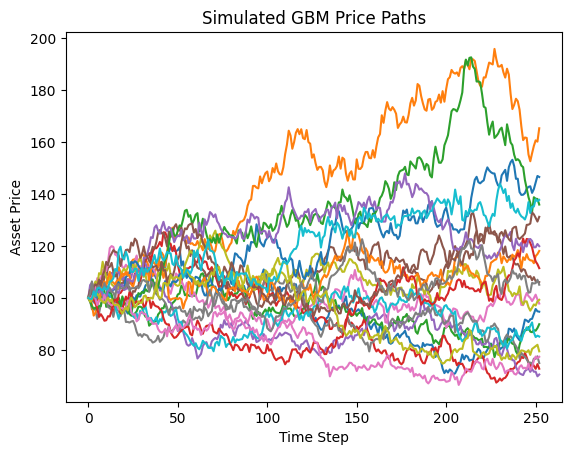

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm_paths(S0, r, sigma, T, N_steps, N_paths):
    dt = T / N_steps
    paths = np.zeros((N_steps + 1, N_paths))
    paths[0] = S0

    for t in range(1, N_steps + 1):
        Z = np.random.standard_normal(N_paths)
        paths[t] = paths[t-1] * np.exp(
            (r - 0.5 * sigma**2) * dt +
            sigma * np.sqrt(dt) * Z
        )

    return paths

# Parameters
S0 = 100
r = 0.05
sigma = 0.30
T = 1.0
N_steps = 252
N_paths = 20

paths = simulate_gbm_paths(S0, r, sigma, T, N_steps, N_paths)

plt.figure()
plt.plot(paths)
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.title("Simulated GBM Price Paths")
plt.show()

Although each path begins at the same initial price, the randomness
in the Brownian increments causes trajectories to diverge over time.

To better visualise the stochastic nature of the process,
we now simulate and plot a single price path.

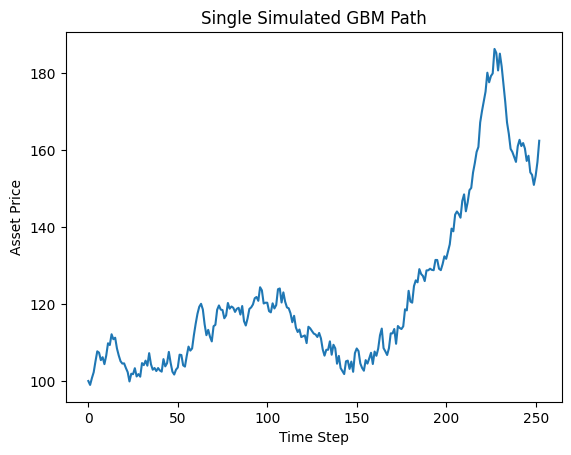

In [84]:
single_path = simulate_gbm_paths(S0, r, sigma, T, N_steps, 1)

plt.figure()
plt.plot(single_path)
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.title("Single Simulated GBM Path")
plt.show()

The single trajectory highlights the multiplicative randomness
of the process. Even though the drift term pushes the asset upward
on average, realised paths can deviate significantly.

We now use Monte Carlo simulation to estimate the price
of a European call option.

#### **Monte Carlo Pricing**

Under risk-neutral pricing:

$$
C_0 = e^{-rT} \mathbb{E}^{\mathbb{Q}}[\max(S_T - K, 0)].
$$

We approximate this expectation by simulating many independent
terminal prices and averaging the discounted payoffs.


In [85]:
def monte_carlo_call_price(S0, K, T, r, sigma, N_sim):
    Z = np.random.standard_normal(N_sim)

    ST = S0 * np.exp(
        (r - 0.5 * sigma**2) * T +
        sigma * np.sqrt(T) * Z
    )

    payoffs = np.maximum(ST - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

# Compare analytical and Monte Carlo prices
N_sim = 100000

mc_price = monte_carlo_call_price(S0, K, T, r, sigma, N_sim)
bs_price = black_scholes_call(S0, K, T, r, sigma)

bs_price, mc_price

(np.float64(14.231254785985819), np.float64(14.272688895502542))

As the number of simulations increases, the Monte Carlo estimate
converges to the analytical Black–Scholes price.

This convergence occurs at rate:

$$
\text{Error} \sim \frac{1}{\sqrt{N}}.
$$

We illustrate this convergence behaviour below.


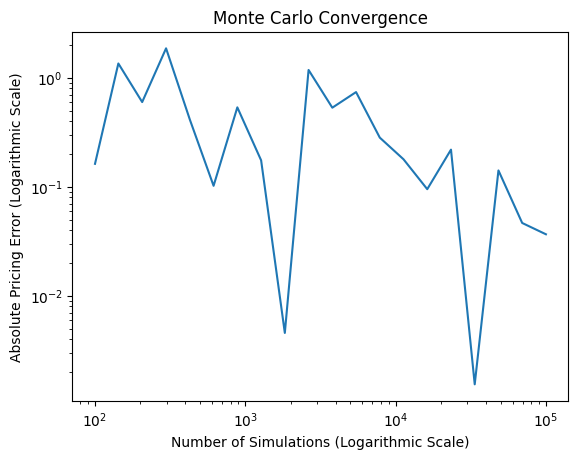

In [86]:
simulations = np.logspace(2, 5, 20, dtype=int)
errors = []

for N in simulations:
    mc_estimate = monte_carlo_call_price(S0, K, T, r, sigma, N)
    errors.append(abs(mc_estimate - bs_price))

plt.figure()
plt.plot(simulations, errors)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Simulations (Logarithmic Scale)")
plt.ylabel("Absolute Pricing Error (Logarithmic Scale)")
plt.title("Monte Carlo Convergence")
plt.show()

The approximately linear relationship in log-log scale confirms
the theoretical convergence rate of Monte Carlo methods.

This section demonstrates that when the true data-generating process
matches the Black–Scholes assumptions, analytical and simulation-based
pricing agree.

In the next section, we explore what happens when these assumptions
fail to hold.

----

# **2. Where The Black Scholes Model Fails**

The Black–Scholes framework is internally consistent and mathematically elegant. However, its assumptions impose strong structural constraints on asset dynamics.

Real financial markets exhibit empirical properties that systematically violate
these assumptions. Understanding these deviations is essential in assessing
model risk.

### **2.1. Empirical Stylised Facts**

#### **Heavy Tails**

Under geometric Brownian motion, log-returns are normally distributed:

$$
\ln\left(\frac{S_T}{S_0}\right) \sim \mathcal{N}\left(
\left(r - \frac{1}{2}\sigma^2\right)T, \sigma^2 T
\right).
$$

The normal distribution has exponentially decaying tails.

Actual return distributions, however, exhibit fat tails, meaning large moves occur more frequently than predicted by a Gaussian model.

This leads to systematic underestimation of extreme events
when using Black–Scholes assumptions.


#### **Volatility Clustering**

Black–Scholes assumes constant volatility $\sigma$.

In real markets, volatility varies over time and tends to cluster where periods of high volatility are followed by high volatility, and calm periods follow calm periods.

This phenomenon cannot be captured by a constant-variance diffusion model.


#### **Jumps and Discontinuities**

Geometric Brownian motion produces continuous sample paths.

In practice, asset prices exhibit sudden jumps due to:
- Earnings announcements
- Macroeconomic releases
- Geopolitical events
- Liquidity shocks

Such discontinuities are structurally impossible under standard Brownian motion.



#### **Volatility Smile and Skew**

One of the strongest pieces of evidence against the Black–Scholes model
comes from observed option prices.

If Black-Scholes were correct, implied volatility would be constant
across strikes and maturities.

Empirically, implied volatility varies systematically with strike,
producing a volatility smile or skew.

This indicates that the market assigns different probabilities
to extreme upward and downward moves than those implied by log-normal dynamics.


### **2.2. Limitations of Log-Normal Diffusion Models**

The geometric Brownian motion assumption imposes three structural restrictions:

1. Returns are conditionally normal.
2. Variance grows linearly with time.
3. Paths evolve continuously with no jumps.

These restrictions imply thin tails and symmetric return distributions.

As a consequence:

- Deep out-of-the-money options tend to be systematically mispriced.
- Tail risk is underestimated.
- Extreme scenarios are underrepresented.

Importantly, these are not parameter errors.
Even with perfectly calibrated volatility,
the model remains structurally constrained.

This motivates the introduction of richer stochastic processes
that allow for discontinuities and heavier tails.

In the next section, we introduce the Merton jump-diffusion model,
which extends geometric Brownian motion by incorporating
random jump arrivals.

----

# **3. The Jump Diffusion Model**

To address the structural limitations of geometric Brownian motion,
we introduce an alternative stochastic process that incorporates sudden,
discrete jumps in asset prices.

The Merton jump-diffusion model, which augments the standard
diffusion process with a compound Poisson jump component.

### **3.1. The Merton Jump-Diffusion Model**

Under the jump-diffusion framework, the asset price evolves according to:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t + S_t (J - 1) dN_t,
$$

where:

- $W_t$ is a standard Brownian motion,
- $N_t$ is a Poisson process with intensity $\lambda$,
- $J$ represents the random jump multiplier.


#### **Interpretation of Components**

The model consists of two independent sources of randomness:

1. **Continuous Diffusion Component**

$$
\mu S_t dt + \sigma S_t dW_t
$$

This is identical to the Black–Scholes diffusion term.

2. **Jump Component**

$$
S_t (J - 1) dN_t
$$

- The Poisson process $N_t$ governs the arrival of jumps.
- The intensity $\lambda$ represents the expected number of jumps per unit time.
- When a jump occurs, the asset price is multiplied by $J$.

If $J > 1$, the jump is upward.  
If $J < 1$, the jump is downward.

#### **Distribution of Jump Sizes**

In the Merton model, jump sizes are assumed log-normally distributed:

$$
\ln J \sim \mathcal{N}(\mu_J, \sigma_J^2).
$$

This ensures that prices remain strictly positive.

#### **Risk-Neutral Dynamics**

Under the risk-neutral measure, the drift must be adjusted
to preserve the martingale property of discounted prices.

The risk-neutral jump-diffusion dynamics become:

$$
dS_t =
\left(
r - \lambda \kappa
\right) S_t dt
+ \sigma S_t dW_t^{\mathbb{Q}}
+ S_t (J - 1) dN_t,
$$

where

$$
\kappa = \mathbb{E}[J - 1].
$$

The term $\lambda \kappa$ adjusts the drift to compensate
for the expected jump contribution.

#### **Terminal Price Representation**

The solution to the jump-diffusion SDE can be written as:

$$
S_T =
S_0
\exp\left(
\left(
r - \lambda \kappa - \frac{1}{2}\sigma^2
\right)T
+ \sigma W_T
\right)
\prod_{i=1}^{N_T} J_i,
$$

where:

- $N_T$ is the total number of jumps by time $T$,
- $J_i$ are independent jump multipliers.

This representation shows that:

- The diffusion part governs continuous evolution.
- The product term introduces discrete multiplicative jumps.

#### **Why This Model Matters**

The jump-diffusion model produces:

- Heavy-tailed return distributions,
- Discontinuous price paths,
- Asymmetric behaviour (if jump distribution is asymmetric).

Importantly, these features emerge from structural changes
to the underlying stochastic process — not merely from parameter adjustments.

In the next section, we simulate jump-diffusion paths
and compare them visually to geometric Brownian motion.

### **3.2. Monte Carlo Simulation of Jump-Diffusion Paths**

To simulate the jump-diffusion process numerically, we discretise time
into steps of length $\Delta t$.

From the risk-neutral dynamics:

$$
dS_t =
(r - \lambda \kappa) S_t dt
+ \sigma S_t dW_t
+ S_t (J - 1) dN_t,
$$

each small time interval contains two independent components:

#### **Diffusion Step**

$$
S_{t+\Delta t}^{(diff)}
=
S_t
\exp\left(
(r - \lambda \kappa - \tfrac{1}{2}\sigma^2)\Delta t
+ \sigma \sqrt{\Delta t} Z
\right),
$$

where $Z \sim \mathcal{N}(0,1)$.

#### **Jump Step**

The number of jumps in $\Delta t$ follows:

$$
N \sim \text{Poisson}(\lambda \Delta t).
$$

If $N > 0$, we multiply the price by:

$$
\prod_{i=1}^{N} J_i.
$$

Combining both effects yields a simple simulation algorithm.

We now implement this in Python and compare the resulting paths
to standard geometric Brownian motion.

In [87]:
def simulate_jump_diffusion_paths(
    S0, r, sigma, T,
    lam, muJ, sigmaJ,
    N_steps, N_paths
):
    dt = T / N_steps

    paths = np.zeros((N_steps + 1, N_paths))
    paths[0] = S0

    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1

    for t in range(1, N_steps + 1):

        # diffusion
        Z = np.random.standard_normal(N_paths)
        diffusion = np.exp(
            (r - lam * kappa - 0.5 * sigma**2) * dt
            + sigma * np.sqrt(dt) * Z
        )

        # jumps
        N_jump = np.random.poisson(lam * dt, N_paths)
        jump_sizes = np.exp(muJ + sigmaJ * np.random.standard_normal(N_paths))
        jump_factor = np.where(N_jump > 0, jump_sizes**N_jump, 1.0)

        paths[t] = paths[t-1] * diffusion * jump_factor

    return paths

#### **Visual Comparison: GBM vs Jump-Diffusion**

We first compare multiple simulated paths.

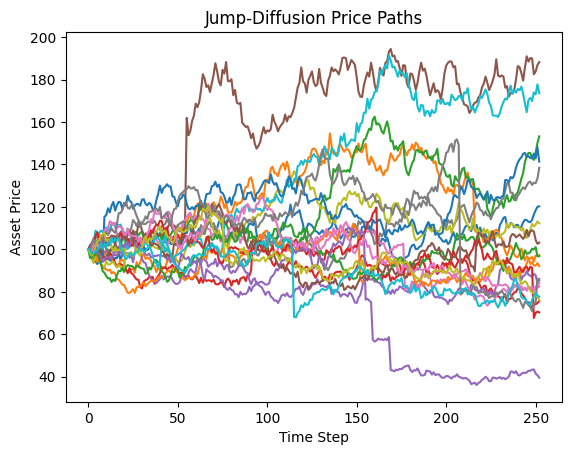

In [88]:
# Jump parameters
lam = 1.0  # One jump per year on average
muJ = -0.1  # Average downward jump
sigmaJ = 0.25

jd_paths = simulate_jump_diffusion_paths(
    S0, r, sigma, T,
    lam, muJ, sigmaJ,
    N_steps, 20
)

plt.figure()
plt.plot(jd_paths)
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.title("Jump-Diffusion Price Paths")
plt.show()

Compared with the earlier GBM simulation, the paths now exhibit
visible discontinuities. Sudden drops and spikes occur at random times,
capturing behaviour frequently observed in real markets.

To emphasise the randomness of individual trajectories,
we next plot a single path.


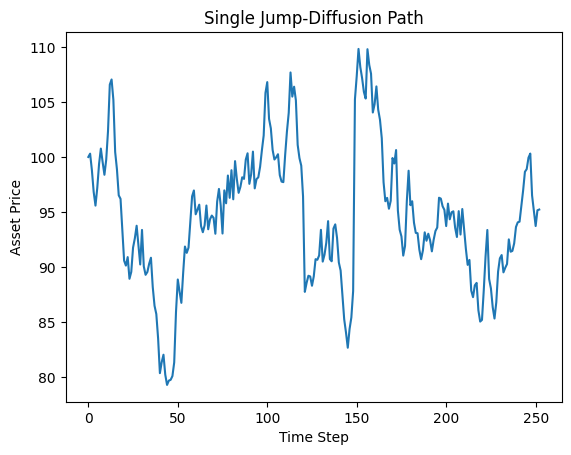

In [89]:
single_jd = simulate_jump_diffusion_paths(
    S0, r, sigma, T,
    lam, muJ, sigmaJ,
    N_steps, 1
)

plt.figure()
plt.plot(single_jd)
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.title("Single Jump-Diffusion Path")
plt.show()

The jump times are clearly visible as discrete discontinuities,
in contrast to the smooth evolution produced by Brownian motion.

#### **Side-by-Side Comparison**

Finally, we compare GBM and jump-diffusion directly.

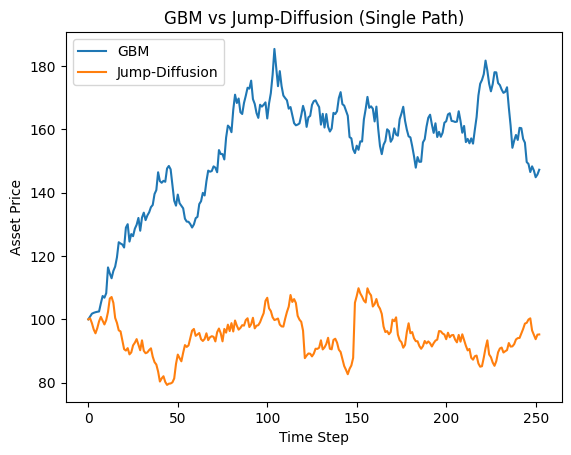

In [90]:
gbm_single = simulate_gbm_paths(S0, r, sigma, T, N_steps, 1)

plt.figure()
plt.plot(gbm_single, label="GBM")
plt.plot(single_jd, label="Jump-Diffusion")
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.title("GBM vs Jump-Diffusion (Single Path)")
plt.legend()
plt.show()

The contrast highlights a key structural difference:

- GBM paths are smooth and continuous.
- Jump-diffusion paths exhibit sudden discontinuities.

These jumps introduce heavier tails and more extreme outcomes,
properties that better match empirical financial data.

In the next section, we examine how these structural differences
impact option pricing.


----

# **4. Option Pricing Under Model Misspecification**

We have considered two separate frameworks:

- Black-Scholes: continuous geometric Brownian motion with closed-form pricing,
- Jump-diffusion: richer dynamics with discontinuities, priced via simulation.

In practice, however, models are rarely perfectly specified.

A common situation is:

- The true data-generating process follows complex dynamics,
- The pricing model remains a simpler approximation.

This mismatch introduces model misspecification risk.

To study this effect, we perform the following experiment:

1. Simulate asset prices under the jump-diffusion model (treated as the true world).
2. Compute the option price using Monte Carlo simulation (ground truth).
3. Compute the Black-Scholes price using the same inputs.
4. Compare the difference.

If the Black-Scholes assumptions were structurally correct,
both prices would agree. Any systematic difference therefore
quantifies model risk.

## **4.1. Option Pricing Comparison: Black-Scholes vs Jump-Diffusion**

Under risk-neutral valuation, the true option price is:

$$
C_0^{true}
=
e^{-rT}\mathbb{E}[\max(S_T - K, 0)],
$$

where $S_T$ is generated by the jump-diffusion process.

We estimate this expectation using Monte Carlo simulation.

We then compare it with the Black–Scholes analytical price:

$$
C_0^{BS}.
$$

The difference

$$
\text{Model Error} = C_0^{BS} - C_0^{true}
$$

measures the pricing bias introduced by model misspecification.

In [91]:
def monte_carlo_jump_call_price(
    S0, K, T, r, sigma,
    lam, muJ, sigmaJ,
    N_sim
):
    Z = np.random.standard_normal(N_sim)

    # Number of jumps
    N_jump = np.random.poisson(lam * T, N_sim)

    # Jump multipliers
    J = np.exp(muJ + sigmaJ * np.random.standard_normal(N_sim))
    jump_factor = J ** N_jump

    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1

    ST = S0 * np.exp(
        (r - lam * kappa - 0.5 * sigma**2) * T
        + sigma * np.sqrt(T) * Z
    ) * jump_factor

    payoffs = np.maximum(ST - K, 0)

    return np.exp(-r * T) * np.mean(payoffs)

In [92]:
K = 100
N_sim = 200_000

true_price = monte_carlo_jump_call_price(
    S0, K, T, r, sigma,
    lam, muJ, sigmaJ,
    N_sim
)

bs_price = black_scholes_call(S0, K, T, r, sigma)

true_price, bs_price, bs_price - true_price

(np.float64(21.338714139693906),
 np.float64(14.231254785985819),
 np.float64(-7.107459353708087))

If the prices differ systematically, this indicates that
Black-Scholes is structurally mispricing the option.

The discrepancy arises because:

- Black-Scholes underestimates tail risk,
- jumps increase the probability of extreme outcomes,
- option payoffs are convex and therefore sensitive to tails.

As a result, ignoring jumps often leads to biased prices,
particularly for out-of-the-money options.

To better understand how this mispricing varies across contracts,
we next compute pricing errors across a range of strikes.

## **4.2. Mispricing Across Strikes**

The previous experiment compared pricing for a single strike.

However, model misspecification rarely affects all options equally.
In practice, pricing errors vary systematically with strike.

This phenomenon is directly related to the well-known
volatility smile observed in markets.

If the Black–Scholes assumptions were correct, implied volatility would be constant,
and pricing errors would be close to zero across all strikes.

To test this, we:

1. Fix the model parameters,
2. Vary the strike price $K$,
3. Compute:
   - the true price under jump-diffusion (Monte Carlo),
   - the Black–Scholes price,
4. Measure the difference.

This reveals how structural model errors depend on moneyness.

In [93]:
strikes = np.linspace(60, 140, 25)

true_prices = []
bs_prices = []
errors = []

for K in strikes:
    true_p = monte_carlo_jump_call_price(
        S0, K, T, r, sigma,
        lam, muJ, sigmaJ,
        100_000
    )

    bs_p = black_scholes_call(S0, K, T, r, sigma)

    true_prices.append(true_p)
    bs_prices.append(bs_p)
    errors.append(bs_p - true_p)

true_prices = np.array(true_prices)
bs_prices = np.array(bs_prices)
errors = np.array(errors)

#### **Price Comparison**

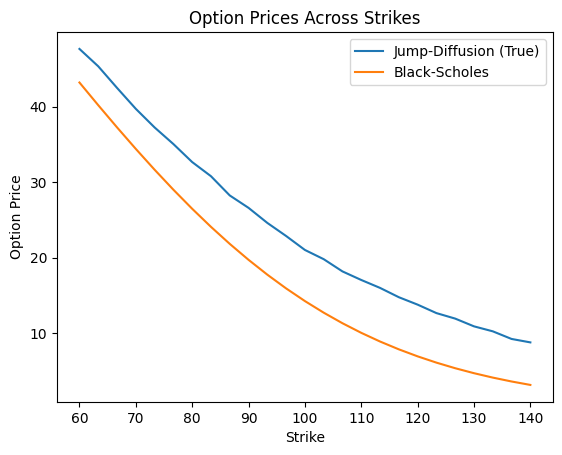

In [94]:
plt.figure()
plt.plot(strikes, true_prices, label="Jump-Diffusion (True)")
plt.plot(strikes, bs_prices, label="Black-Scholes")
plt.xlabel("Strike")
plt.ylabel("Option Price")
plt.title("Option Prices Across Strikes")
plt.legend()
plt.show()

The two curves diverge most strongly for deep out-of-the-money
and deep in-the-money options.

This reflects the increased importance of tail risk
for extreme payoffs.

#### **Pricing Error**

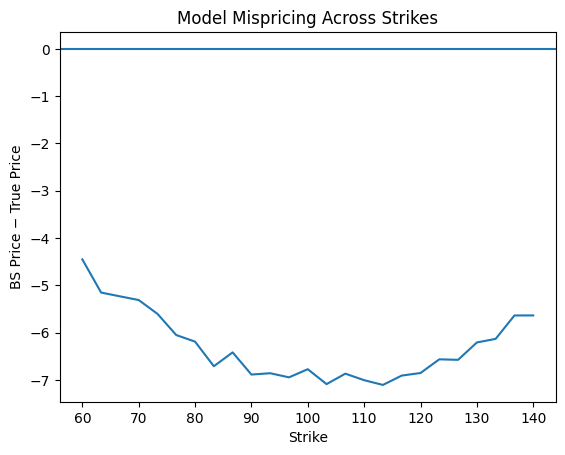

In [95]:
plt.figure()
plt.plot(strikes, errors)
plt.axhline(0)
plt.xlabel("Strike")
plt.ylabel("BS Price − True Price")
plt.title("Model Mispricing Across Strikes")
plt.show()

The non-zero pricing error demonstrates that Black–Scholes systematically misprices options when the true dynamics include jumps.

In particular:

- Out-of-the-money options are often underpriced,
- Tail events are underestimated,
- Pricing bias grows with jump intensity.

This behaviour mirrors the volatility smile observed in real markets.

Importantly, this effect is not due to poor calibration but from structural assumptions in the model itself.

In the next section, we quantify this model risk more formallyby analysing the distribution of pricing errors and studying their sensitivity to jump intensity.

----

# **5. Quantifying Model Risk**

The previous section showed that Black–Scholes produces systematic pricing bias
when the true asset dynamics include jumps.

However, pricing error is not deterministic.

Because prices are estimated via Monte Carlo simulation, and because realised
market paths are random, model misspecification introduces uncertainty in addition to bias.

In practice, this uncertainty translates into profit and loss (P/L) risk:

- If we price using the wrong model,
- and trade at that price,
- realised outcomes may systematically deviate from expectations.

To better understand this risk, we study the full distribution of pricing errors rather than a single average value.

## **5.1. Distribution of Pricing Errors**

We perform the following experiment:

1. Fix a strike $K$.
2. Repeatedly estimate the option price under jump-diffusion using Monte Carlo.
3. Compare each estimate with the Black–Scholes price.
4. Record the pricing error.

This produces a distribution:

$$
\text{Error} = C^{BS} - C^{true}.
$$

If Black–Scholes were correct, this distribution would be centred around zero.

Any persistent shift or dispersion represents model risk.

In [96]:
def repeated_pricing_errors(
    S0, K, T, r, sigma,
    lam, muJ, sigmaJ,
    N_sim,
    N_trials
):
    bs_price = black_scholes_call(S0, K, T, r, sigma)

    errors = []

    for _ in range(N_trials):
        true_price = monte_carlo_jump_call_price(
            S0, K, T, r, sigma,
            lam, muJ, sigmaJ,
            N_sim
        )
        errors.append(bs_price - true_price)

    return np.array(errors)


K = 100
errors_dist = repeated_pricing_errors(
    S0, K, T, r, sigma,
    lam, muJ, sigmaJ,
    N_sim=20_000,
    N_trials=300
)

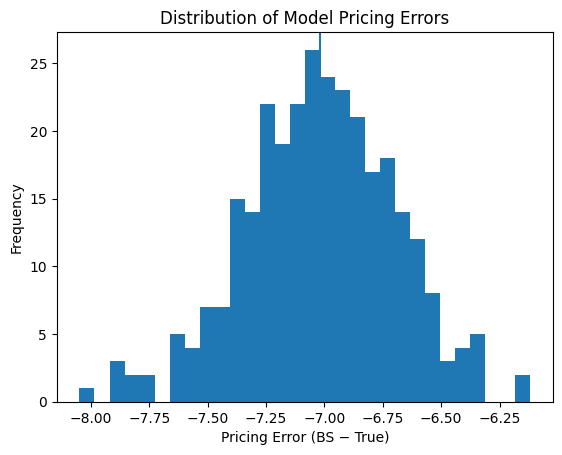

(np.float64(-7.018535254194852), np.float64(0.3262732815687848))

In [97]:
plt.figure()
plt.hist(errors_dist, bins=30)
plt.axvline(np.mean(errors_dist))
plt.xlabel("Pricing Error (BS − True)")
plt.ylabel("Frequency")
plt.title("Distribution of Model Pricing Errors")
plt.show()

np.mean(errors_dist), np.std(errors_dist)

Several features are immediately visible:

- The distribution is not centred at zero (systematic bias),
- There is non-negligible dispersion (estimation uncertainty),
- Errors persist even with large simulation sizes.

Thus, model misspecification creates both:

- Bias (expected loss),
- Variance (risk around that loss).

This mirrors practical trading risk: even if the average mispricing is small,
random fluctuations may still generate substantial realised losses.

## **5.2. Sensitivity to Jump Intensity**

The parameter $\lambda$ controls the expected number of jumps per unit time.

As $\lambda$ increases:

- discontinuities become more frequent,
- tails become heavier,
- deviations from Black–Scholes assumptions grow.

We therefore expect model risk to increase with $\lambda$.

To test this hypothesis, we compute pricing errors for a range of jump intensities.

In [98]:
lambdas = np.linspace(0.0, 2.0, 10)
mean_errors = []

for lam_test in lambdas:
    true_price = monte_carlo_jump_call_price(
        S0, K, T, r, sigma,
        lam_test, muJ, sigmaJ,
        100_000
    )

    bs_price = black_scholes_call(S0, K, T, r, sigma)
    mean_errors.append(bs_price - true_price)

mean_errors = np.array(mean_errors)

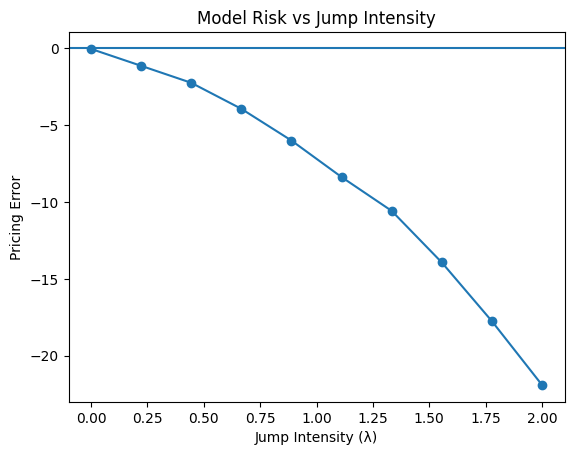

In [99]:
plt.figure()
plt.plot(lambdas, mean_errors, marker="o")
plt.axhline(0)
plt.xlabel("Jump Intensity (λ)")
plt.ylabel("Pricing Error")
plt.title("Model Risk vs Jump Intensity")
plt.show()

The monotonic increase in pricing error confirms that Black–Scholes becomes progressively less reliable as jump activity increases.

When $\lambda = 0$, the models coincide and the error vanishes,
as expected.

This experiment highlights a key insight:

- Model risk is not merely noise. It also scales systematically with structural misspecification.

In the final section, we outline possible extensions, including pricing of exotic derivatives and variance reduction techniques.

----

## **7. Conclusion**

This notebook examined how option pricing depends critically
on modelling assumptions.

Starting from the Black-Scholes framework, we:

- Verified analytical prices using Monte Carlo simulation.
- Identified empirical violations of model assumptions.
- Introduced jump-diffusion dynamics.
- Demonstrated systematic mispricing under model misspecification.
- Quantified the resulting model risk statistically.

The key takeaway is that pricing models are not merely computational tools.
They embed structural beliefs about market behaviour.

----